/var/folders/z6/tqs2tmyx5lg9w9_hb5jtj5m40000gr/T/ipykernel_1605/1875069535.py:56: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  all_trajectories = [odeint(two_body_equations, state, t, args=(mu,))


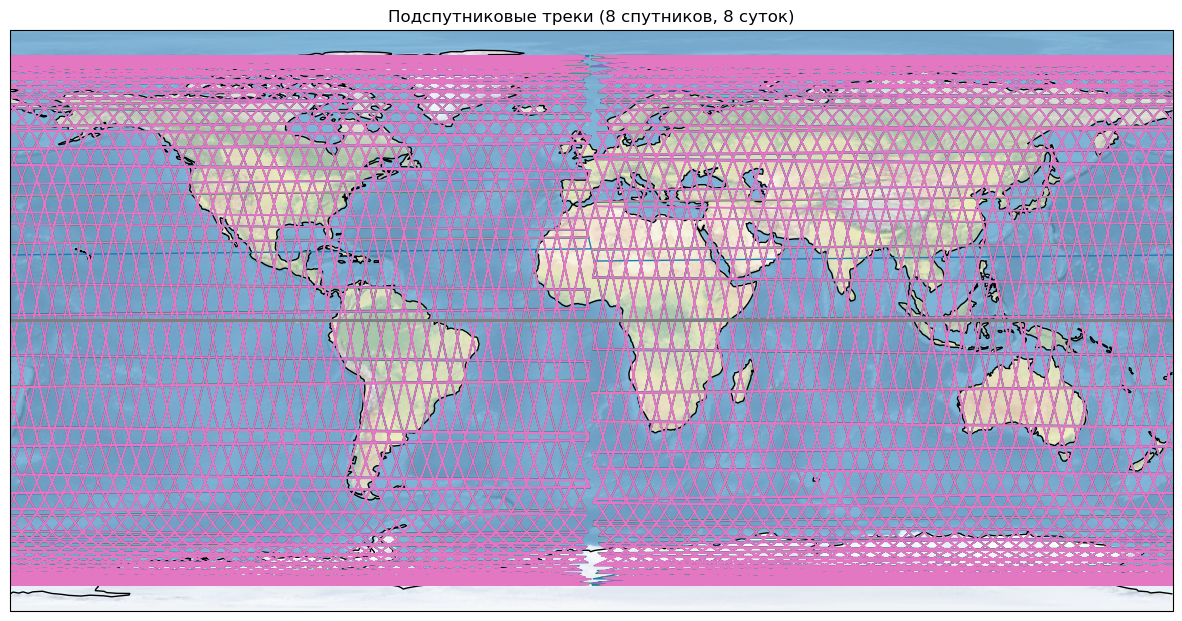

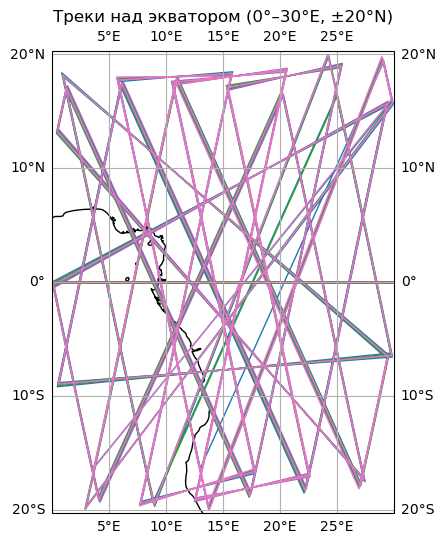

In [23]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# ==================== КОНСТАНТЫ И ПАРАМЕТРЫ ====================
mu = 398600.4415e9      # Гравитационный параметр Земли (м³/с²)
R_earth = 6371302       # Радиус Земли (м)
omega_earth = 7.29211e-5  # Угловая скорость вращения Земли (рад/с)
h = 500000              # Высота орбиты (500 км)
a = R_earth + h         # Большая полуось (м)
i = np.radians(98)      # Наклонение орбиты (98° в радианах)
n_satellites = 8        # Количество спутников
duration_days = 8       # Длительность моделирования (суток)
step_sec = 60           # Шаг интегрирования (секунд)

# ==================== ФУНКЦИИ ====================
def two_body_equations(y, t, mu):
    """Уравнения движения задачи двух тел."""
    r = y[:3]
    v = y[3:]
    r_norm = np.linalg.norm(r)
    drdt = v
    dvdt = -mu * r / r_norm**3
    return np.concatenate([drdt, dvdt])

def initial_conditions(a, i, n_satellites):
    """Генерация начальных условий для группировки."""
    v = np.sqrt(mu / a)  # Орбитальная скорость
    conditions = []
    for k in range(n_satellites):
        Omega = 2 * np.pi * k / n_satellites  # Долгота восходящего узла
        r0 = np.array([a * np.cos(Omega), a * np.sin(Omega), 0])
        v0 = np.array([
            -v * np.sin(Omega) * np.cos(i),
            v * np.cos(Omega) * np.cos(i),
            v * np.sin(i)
        ])
        conditions.append(np.concatenate([r0, v0]))
    return np.array(conditions)

def cartesian_to_geo(r, t):
    """Перевод координат (x,y,z) в (широта, долгота)."""
    x, y, z = r
    lon = np.arctan2(y, x) - omega_earth * t
    lat = np.arctan2(z, np.sqrt(x**2 + y**2))
    return np.degrees(lat), np.degrees(lon % (2 * np.pi))

# ==================== РАСЧЁТ ТРАЕКТОРИЙ ====================
# Временной интервал (8 суток с шагом 60 сек)
t = np.arange(0, duration_days * 86400, step_sec)

# Интегрирование орбит для всех спутников
initial_states = initial_conditions(a, i, n_satellites)
all_trajectories = [odeint(two_body_equations, state, t, args=(mu,)) 
                   for state in initial_states]

# ==================== СОХРАНЕНИЕ В CSV ====================
data = []
for ti, time in enumerate(t):
    row = [time]
    for sat in range(n_satellites):
        r = all_trajectories[sat][ti, :3]
        v = all_trajectories[sat][ti, 3:]
        row.extend(list(r) + list(v))
    data.append(row)

columns = ['t'] + [f'{var}{sat}' 
          for sat in range(1, n_satellites+1) 
          for var in ['x', 'y', 'z', 'vx', 'vy', 'vz']]

pd.DataFrame(data, columns=columns).to_csv('satellite_trajectories.csv', index=False)

# ==================== ВИЗУАЛИЗАЦИЯ ====================
# Глобальная карта
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()

for sat in range(n_satellites):
    lats, lons = [], []
    for ti, time in enumerate(t):
        r = all_trajectories[sat][ti, :3]
        lat, lon = cartesian_to_geo(r, time)
        lats.append(lat)
        lons.append(lon)
    ax.plot(lons, lats, linewidth=1, transform=ccrs.PlateCarree())

plt.title('Подспутниковые треки (8 спутников, 8 суток)')
plt.savefig('global_tracks.png', dpi=300)

# Локальная карта (0°–30°E, ±20°N)
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([0, 30, -20, 20])

for sat in range(n_satellites):
    lats, lons = [], []
    for ti, time in enumerate(t):
        r = all_trajectories[sat][ti, :3]
        lat, lon = cartesian_to_geo(r, time)
        if (0 <= lon <= 30) and (-20 <= lat <= 20):
            lats.append(lat)
            lons.append(lon)
    ax.plot(lons, lats, linewidth=1, transform=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title('Треки над экватором (0°–30°E, ±20°N)')
plt.savefig('local_tracks.png', dpi=300)
plt.show()